<a href="https://colab.research.google.com/github/ZeeeeCS/Sales-Forcasting-For-retail-store/blob/main/ThirdSalesForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import GridSearchCV
import matplotlib.dates as mdates
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Upload Kaggle API Key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohamedsayedjp","key":"09239f6bbcc96a5d4b5bdc1288f535ea"}'}

In [ ]:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download anirudhchauhan/retail-store-inventory-forecasting-dataset


Dataset URL: https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset
License(s): CC0-1.0
retail-store-inventory-forecasting-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip Dataset
!unzip retail-store-inventory-forecasting-dataset.zip

Archive:  retail-store-inventory-forecasting-dataset.zip
replace retail_store_inventory.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Load Data
data_sales=pd.read_csv('/content/retail_store_inventory.csv')

In [ ]:
data_sales.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
data_sales.shape

(73100, 15)

In [ ]:
# Convert Categorical Columns
data_sales[['Region','Category','Seasonality','Weather Condition']]=data_sales[['Region','Category','Seasonality','Weather Condition']].astype('category')

# **Cleaning and Preprocessing**

In [ ]:
data_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Date                73100 non-null  object  
 1   Store ID            73100 non-null  object  
 2   Product ID          73100 non-null  object  
 3   Category            73100 non-null  category
 4   Region              73100 non-null  category
 5   Inventory Level     73100 non-null  int64   
 6   Units Sold          73100 non-null  int64   
 7   Units Ordered       73100 non-null  int64   
 8   Demand Forecast     73100 non-null  float64 
 9   Price               73100 non-null  float64 
 10  Discount            73100 non-null  int64   
 11  Weather Condition   73100 non-null  category
 12  Holiday/Promotion   73100 non-null  int64   
 13  Competitor Pricing  73100 non-null  float64 
 14  Seasonality         73100 non-null  category
dtypes: category(4), float64(3), int64(5)

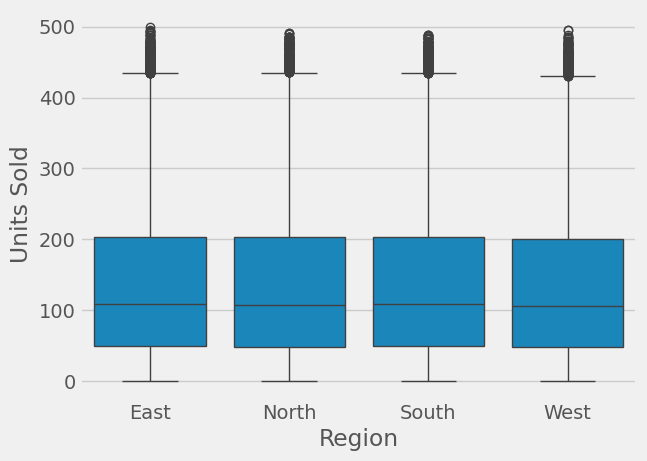

In [ ]:
# Boxplots the distribution of 'Units Sold' by Region
sns.boxplot(data=data_sales,x='Region',y='Units Sold')
plt.show()

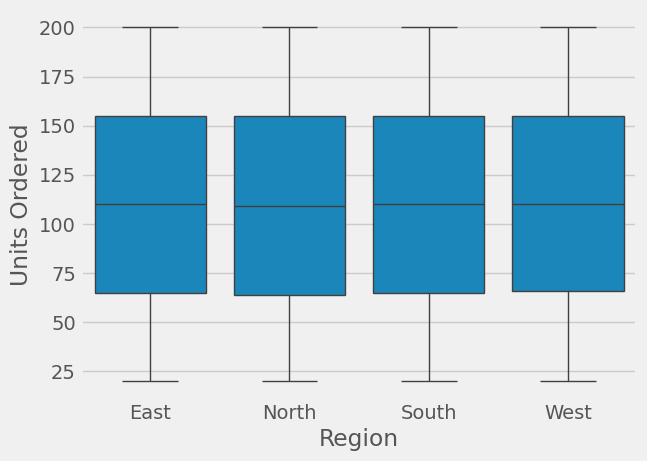

In [ ]:
# Boxplots the distribution of 'Units Ordered' by Region
sns.boxplot(data=data_sales,x='Region',y='Units Ordered')
plt.show()

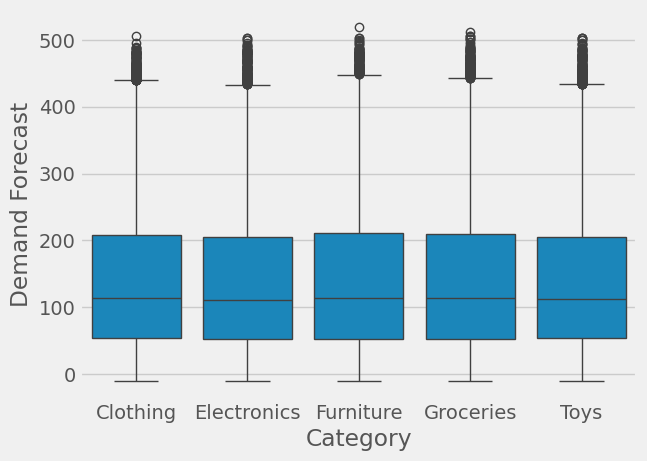

In [ ]:
sns.boxplot(data=data_sales,x='Category',y='Demand Forecast')
plt.show()

In [ ]:
# Check for Missing Values
data_sales.isnull().sum()

,0
Date,0
Store ID,0
Product ID,0
Category,0
Region,0
Inventory Level,0
Units Sold,0
Units Ordered,0
Demand Forecast,0
Price,0


In [ ]:
# Descriptive Statistics
data_sales.describe()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Competitor Pricing
count,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000,73100.000000
mean,274.469877,136.464870,110.004473,141.494720,55.135108,10.009508,0.497305,55.146077
std,129.949514,108.919406,52.277448,109.254076,26.021945,7.083746,0.499996,26.191408
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000
25%,162.000000,49.000000,65.000000,53.670000,32.650000,5.000000,0.000000,32.680000
50%,273.000000,107.000000,110.000000,113.015000,55.050000,10.000000,0.000000,55.010000
75%,387.000000,203.000000,155.000000,208.052500,77.860000,15.000000,1.000000,77.820000
max,500.000000,499.000000,200.000000,518.550000,100.000000,20.000000,1.000000,104.940000


In [ ]:
# Correlation Analysis
corrlation=data_sales.copy()
corrlation.drop(columns=['Date','Store ID','Product ID'],inplace=True)

for col in ['Region','Category','Seasonality','Weather Condition']:
    corrlation[col]=corrlation[col].astype('category').cat.codes

corrlation.corr()

,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
Category,1.000000,0.000841,0.001439,0.000512,-0.001686,0.000495,0.001375,-0.001784,-0.000624,-0.000864,0.000947,-0.001474
Region,0.000841,1.000000,-0.006837,-0.003109,0.003172,-0.002467,-0.003576,-0.002696,0.000209,-0.001074,-0.003389,-0.000785
Inventory Level,0.001439,-0.006837,1.000000,0.589995,0.001060,0.588561,0.009140,0.004889,0.001898,0.003411,0.009365,-0.003425
Units Sold,0.000512,-0.003109,0.589995,1.000000,-0.000930,0.996853,0.001082,0.002576,0.004688,-0.000374,0.001259,-0.003324
Units Ordered,-0.001686,0.003172,0.001060,-0.000930,1.000000,-0.001102,0.004212,-0.000938,-0.001064,0.005446,0.004596,0.003492
Demand Forecast,0.000495,-0.002467,0.588561,0.996853,-0.001102,1.000000,0.000675,0.002338,0.004768,-0.000526,0.000844,-0.003109
Price,0.001375,-0.003576,0.009140,0.001082,0.004212,0.000675,1.000000,0.001509,-0.007715,0.002309,0.993900,0.005095
Discount,-0.001784,-0.002696,0.004889,0.002576,-0.000938,0.002338,0.001509,1.000000,-0.002302,-0.000852,0.001958,-0.004622
Weather Condition,-0.000624,0.000209,0.001898,0.004688,-0.001064,0.004768,-0.007715,-0.002302,1.000000,-0.002408,-0.007440,0.003646
Holiday/Promotion,-0.000864,-0.001074,0.003411,-0.000374,0.005446,-0.000526,0.002309,-0.000852,-0.002408,1.000000,0.001890,-0.001081


# **Visualistaion**

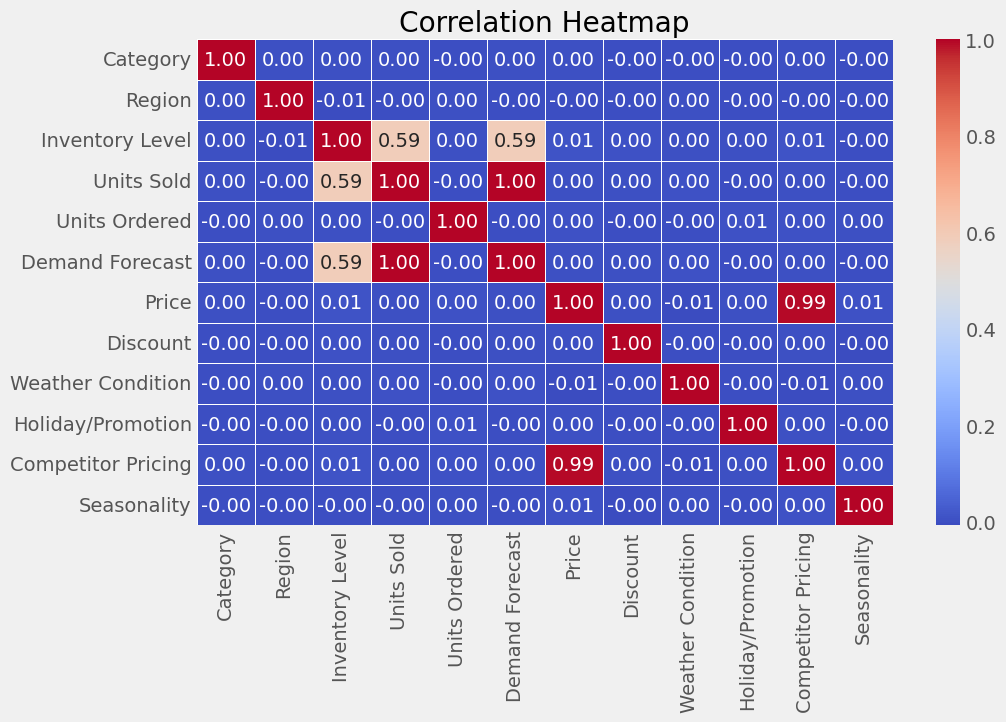

In [ ]:

plt.figure(figsize=(10, 6))
sns.heatmap(corrlation.corr(),annot=True,cmap='coolwarm',linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

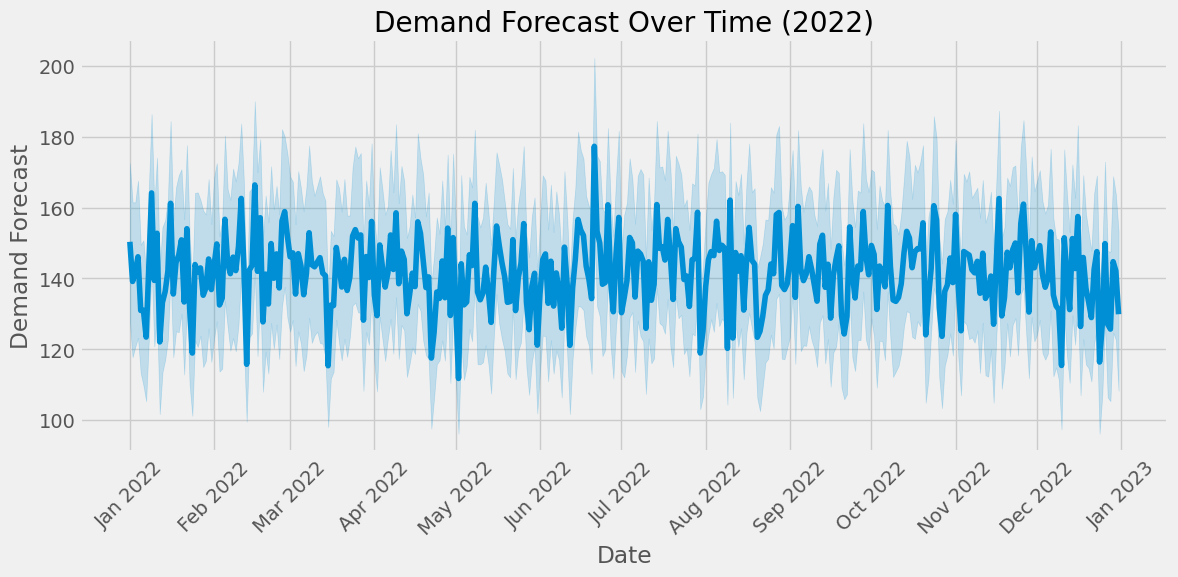

In [ ]:
# Convert 'Date' column to datetime format
data_sales['Date'] = pd.to_datetime(data_sales['Date'])

# Now filter the correct date range
filtered_data = data_sales[(data_sales['Date'] >= '2022-01-01') & (data_sales['Date'] <= '2022-12-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='Date', y='Demand Forecast')

plt.title('Demand Forecast Over Time (2022)')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2022"

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


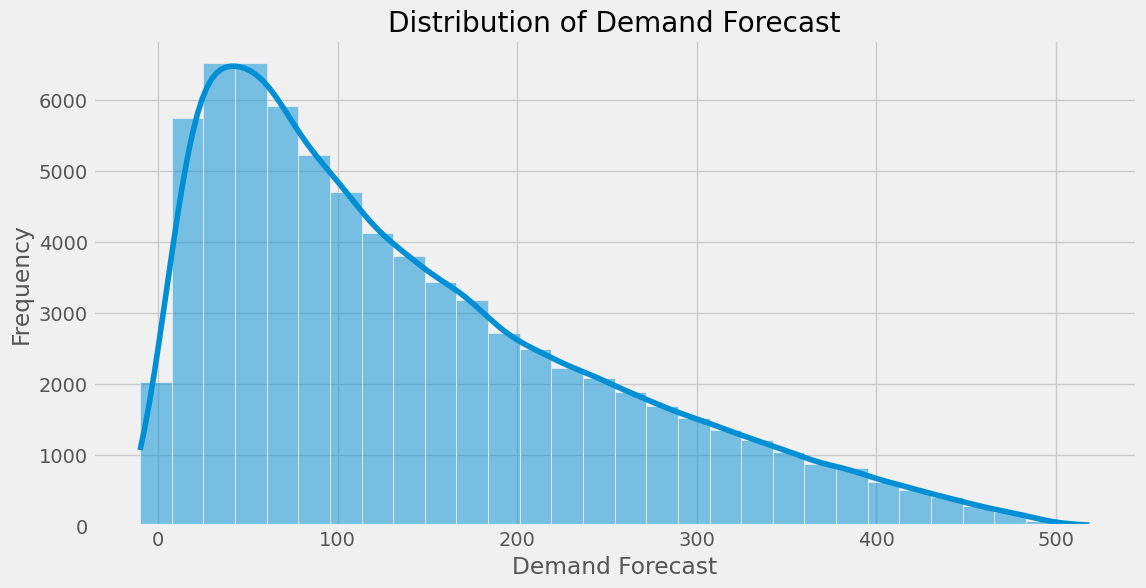

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_sales, x='Demand Forecast', bins=30, kde=True)
plt.title('Distribution of Demand Forecast')
plt.xlabel('Demand Forecast')
plt.ylabel('Frequency')
plt.show()

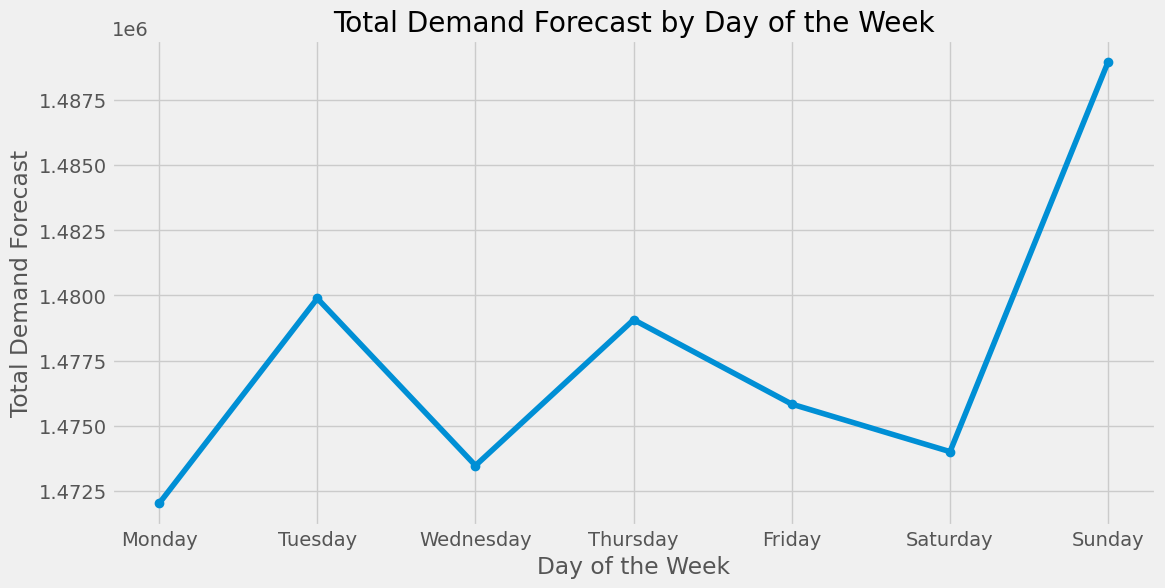

In [ ]:
# Extract day of the week from the Date column
data_sales['DayOfWeek'] = pd.to_datetime(data_sales['Date']).dt.day_name()

# Group by day of the week and sum the uDemand Forecast
daily_sales = data_sales.groupby('DayOfWeek')['Demand Forecast'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the data
plt.figure(figsize=(12, 6))
daily_sales.plot(kind='line', marker='o')
plt.title('Total Demand Forecast by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Demand Forecast')
plt.grid(True)
plt.show()

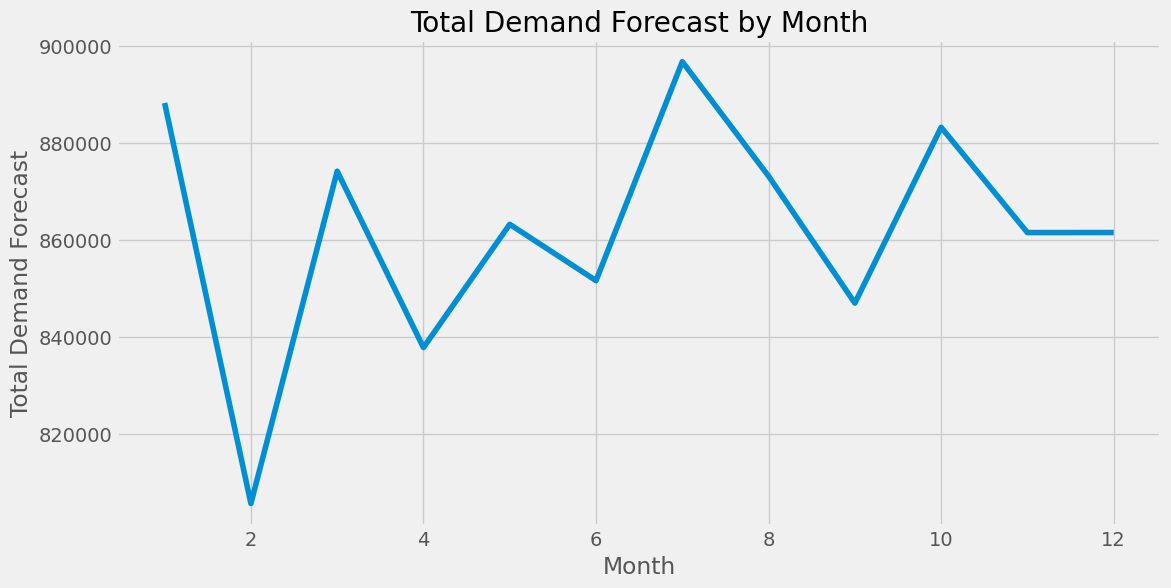

In [ ]:
data_sales['Month'] = pd.to_datetime(data_sales['Date']).dt.month
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_sales, x='Month', y='Demand Forecast', estimator=sum, ci=None)
plt.title('Total Demand Forecast by Month')
plt.xlabel('Month')
plt.ylabel('Total Demand Forecast')
plt.show()

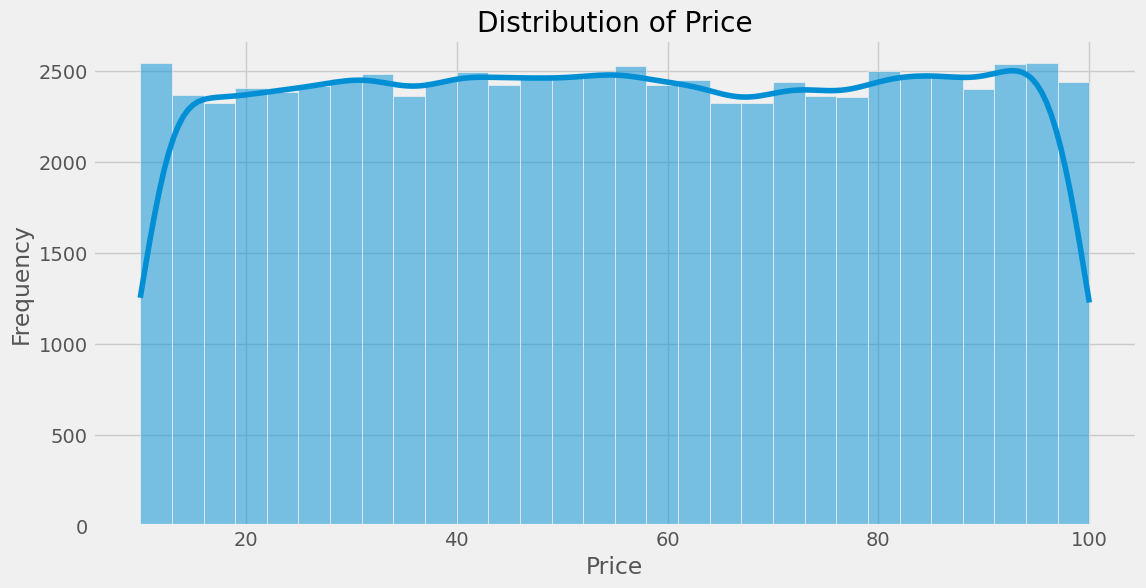

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_sales, x='Price', bins=30, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

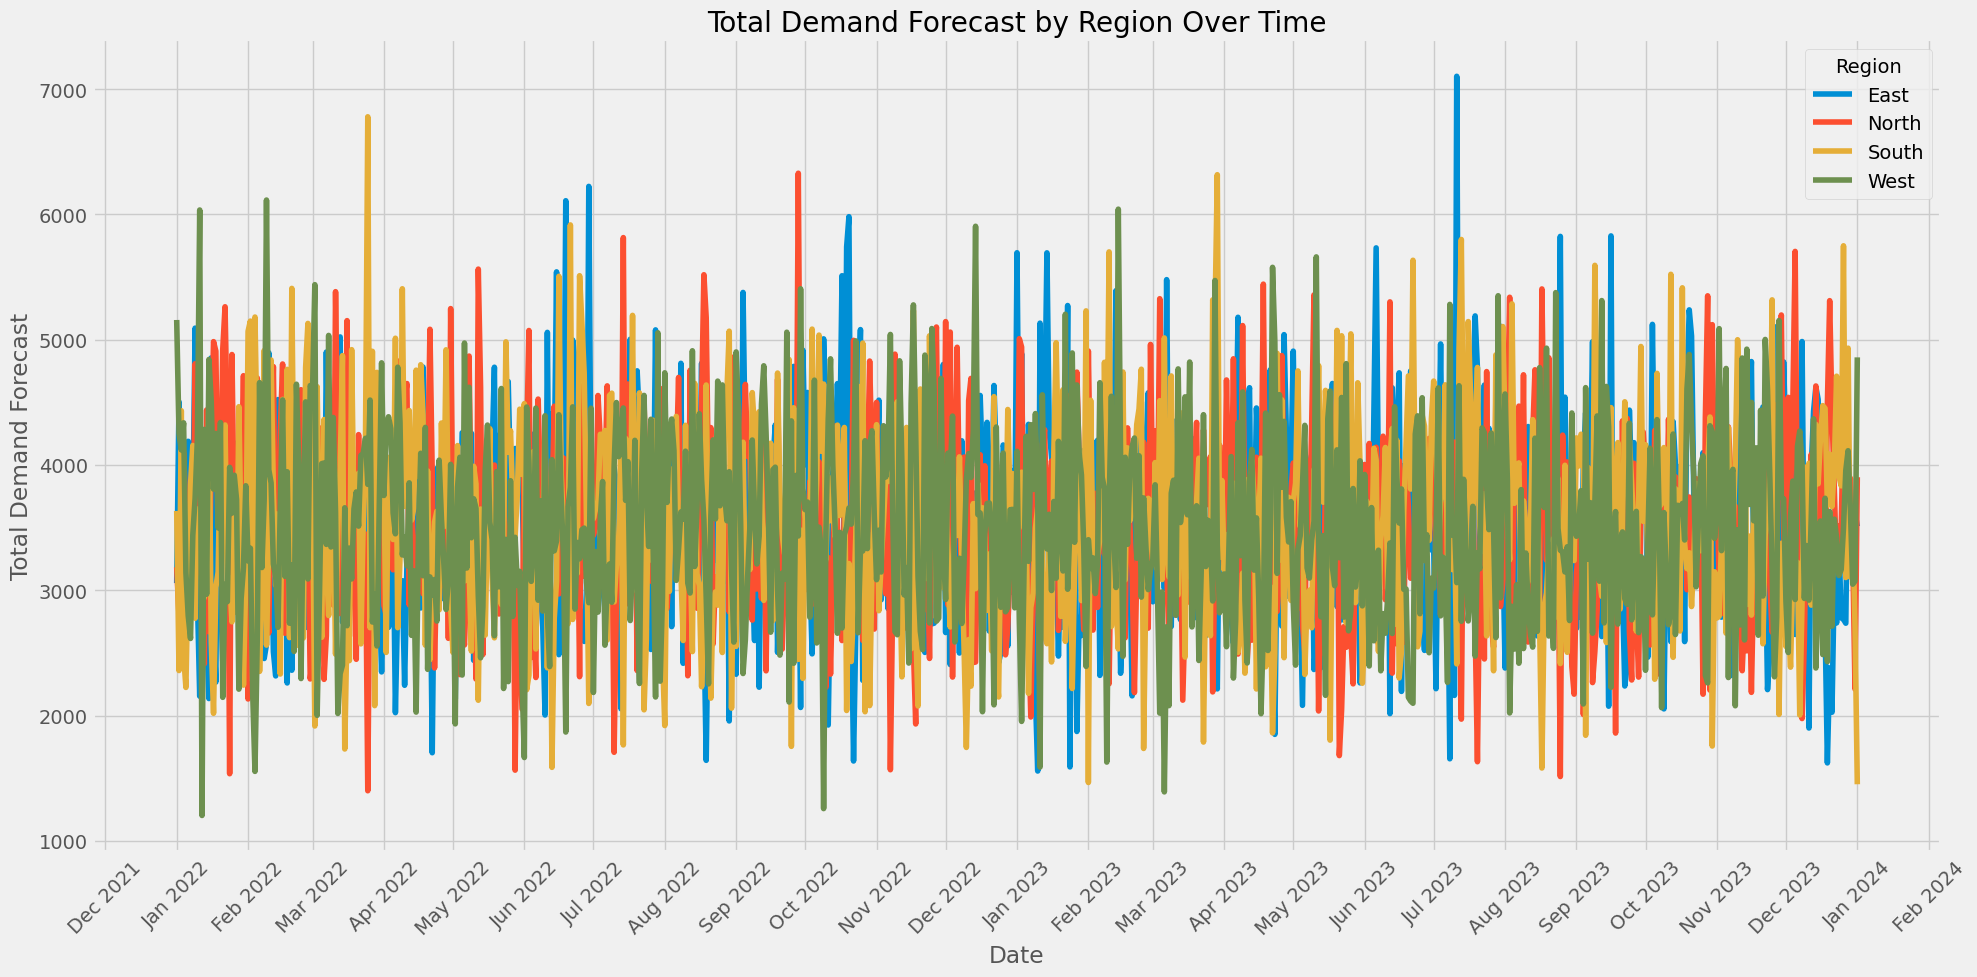

In [ ]:


plt.figure(figsize=(20, 10))
sns.lineplot(data=data_sales, x='Date', y='Demand Forecast', hue='Region', estimator=sum, ci=None)

plt.title('Total Demand Forecast by Region Over Time')
plt.xlabel('Date')
plt.ylabel('Total Demand Forecast')

# Fix the X-axis formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as "Jan 2022"

plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()  # Adjust layout to prevent cutoff
plt.show()


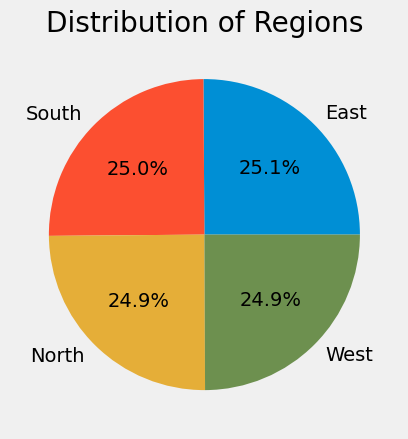

In [ ]:
plt.pie(data_sales['Region'].value_counts(), labels=data_sales['Region'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Regions')
plt.show()

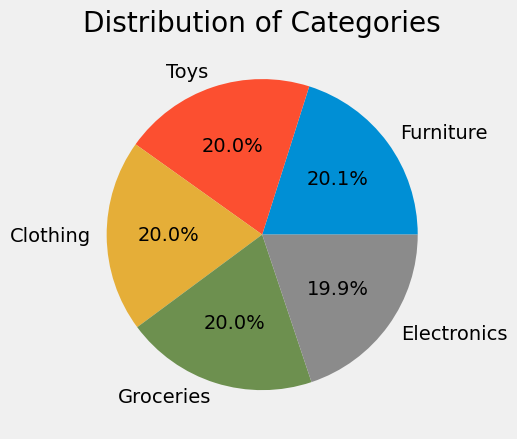

In [ ]:
plt.pie(data_sales['Category'].value_counts(), labels=data_sales['Category'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Categories')
plt.show()

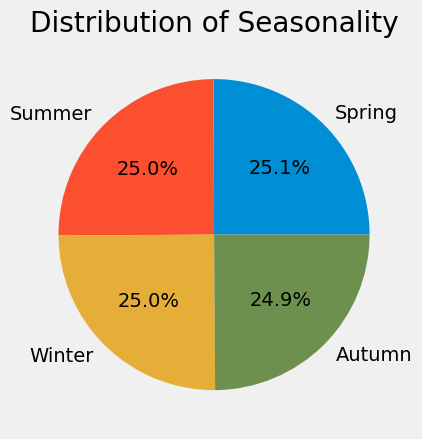

In [ ]:
plt.pie(data_sales['Seasonality'].value_counts(), labels=data_sales['Seasonality'].value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Seasonality')
plt.show()

# **Understanding Trends**

In [ ]:
grouped_data_weather = data_sales.groupby(['Category', 'Weather Condition'])['Demand Forecast'].sum().reset_index()

fig=px.bar(grouped_data_weather,x='Category',y='Demand Forecast',color='Weather Condition',color_discrete_map={  # Assign specific colors
        'Rainy': 'blue',
        'Sunny': 'orange',
        'Cloudy': 'grey',
        'Snowy': 'lightblue'
    })
fig.show()

In [ ]:
grouped_data_area = data_sales.groupby(['Date', 'Region'])['Demand Forecast'].sum().reset_index()
px.area(grouped_data_area,x='Date',y='Demand Forecast',color='Region')

In [ ]:
grouped_data_region = data_sales.groupby(['Category', 'Region'])['Demand Forecast'].sum().reset_index()
px.bar(grouped_data_region,x='Category',y='Demand Forecast',color='Region',barmode='group')

In [ ]:
grouped_data_seasonality = data_sales.groupby(['Category', 'Seasonality'])['Demand Forecast'].sum().reset_index()
px.bar(grouped_data_seasonality,x='Category',y='Demand Forecast',color='Seasonality',barmode='group')


In [ ]:
pip install prophet

# **Feature Engineering**

In [ ]:
data_sales['Date'].min(),data_sales['Date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2024-01-01 00:00:00'))

In [ ]:
# Step 1: Prepare Prophet Data
# Step 1: Aggregate demand by day
daily_df = data_sales.copy()
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Group by day: total demand per date
daily_df = daily_df.groupby('Date', as_index=False)['Units Sold'].sum()

# Add engineered features
daily_df['day_of_week'] = daily_df['Date'].dt.dayofweek
daily_df['month'] = daily_df['Date'].dt.month
daily_df['is_weekend'] = daily_df['day_of_week'].isin([5, 6]).astype(int)


# Rename for Prophet
daily_df = daily_df.rename(columns={'Date': 'ds', 'Units Sold': 'y'})


In [ ]:
daily_df.shape


(731, 5)

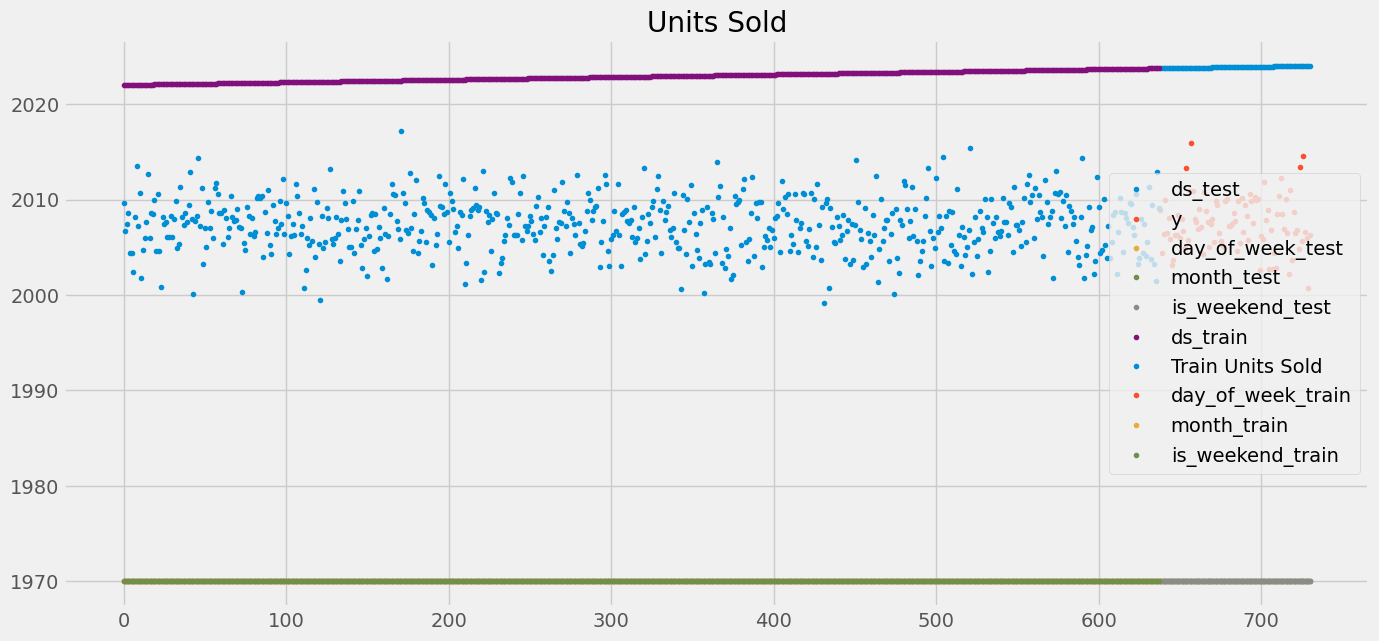

In [ ]:
# spliting by date
split_date = '2023-10-01'
train_df = daily_df[daily_df['ds'] < split_date]
test_df = daily_df[daily_df['ds'] >= split_date]

test_df.rename(columns={'y':'Test Units Sold'})
test_df.join(train_df.rename(columns={'y':'Train Units Sold'}),
how='outer',lsuffix='_test',
    rsuffix='_train').plot(figsize=(15, 7),title = 'Units Sold', style='.')
plt.show()

In [ ]:
test_df.shape,train_df.shape

((93, 5), (638, 5))

# **Modeling and Trends**

In [ ]:

# Step 3: Prophet Model with Regressors
m = Prophet()
m.add_regressor('day_of_week')
m.add_regressor('month')
m.add_regressor('is_weekend')

# Train the model
m.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])

# Step 4: Create future dataframe and forecast
future = m.make_future_dataframe(periods=len(test_df), freq='D')
future['day_of_week'] = future['ds'].dt.dayofweek
future['month'] = future['ds'].dt.month
future['is_weekend'] = future['day_of_week'].isin([5, 6]).astype(int)

forecast = m.predict(future)

# Step 5: Evaluation
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]
y_true = test_df['y'].values
y_pred = forecast_test['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppd3vl9kd/j4x67c8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppd3vl9kd/4iptpukh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45092', 'data', 'file=/tmp/tmppd3vl9kd/j4x67c8r.json', 'init=/tmp/tmppd3vl9kd/4iptpukh.json', 'output', 'file=/tmp/tmppd3vl9kd/prophet_modelw8wy6d2x/prophet_model-20250428154226.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 1027.57
MAE: 801.07
MAPE: 5.81%


Trend and Seasonality Analysis

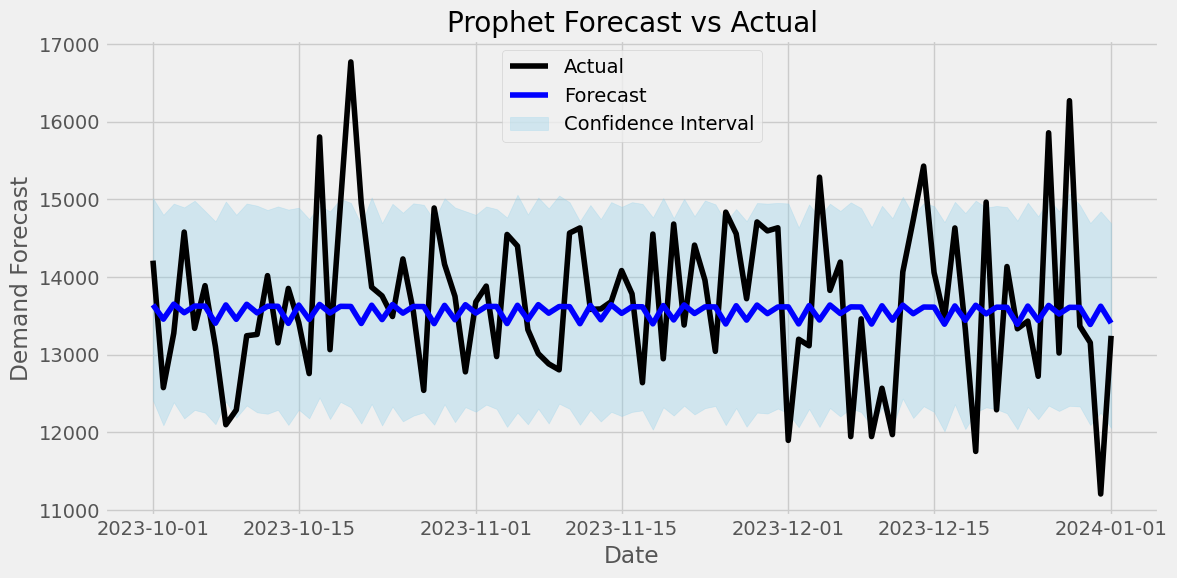

In [ ]:
# Step 6: Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], y_true, label='Actual', color='black')
plt.plot(test_df['ds'], y_pred, label='Forecast', color='blue')
plt.fill_between(test_df['ds'],
                 forecast_test['yhat_lower'],
                 forecast_test['yhat_upper'],
                 color='skyblue', alpha=0.3, label='Confidence Interval')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Demand Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


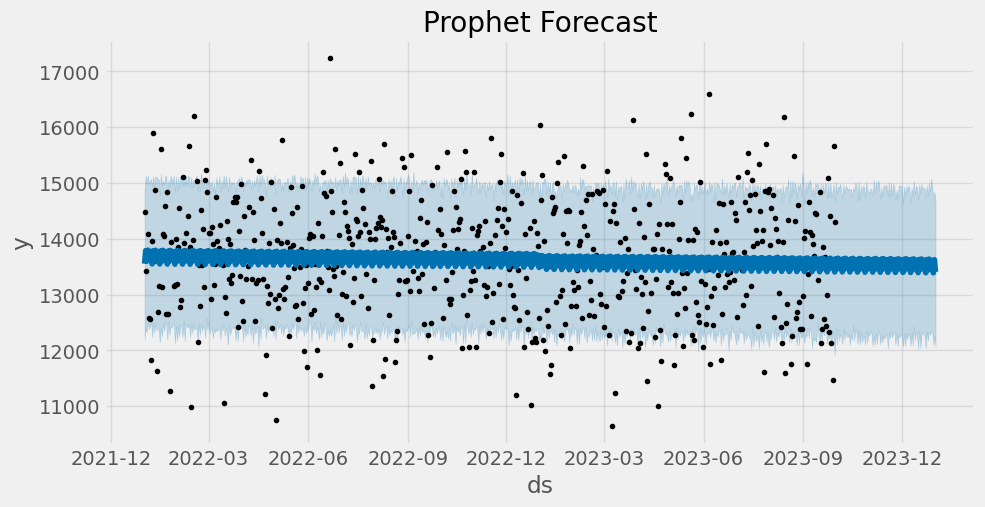

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = m.plot(forecast, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

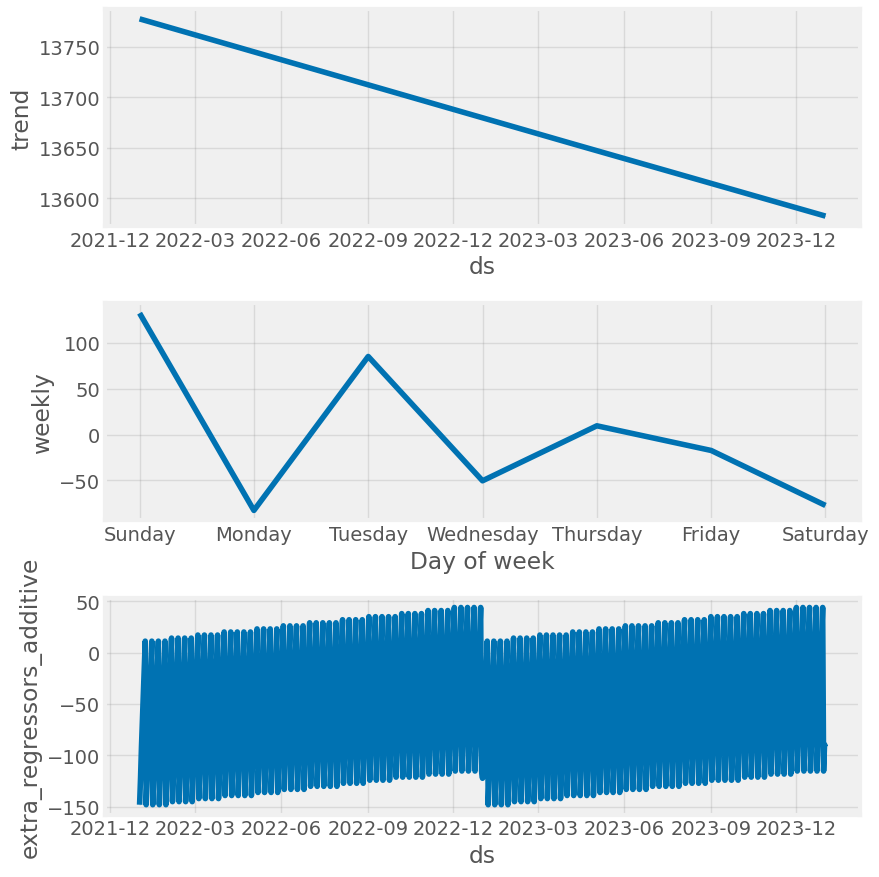

In [ ]:
fig = m.plot_components(forecast)
plt.show()

In [ ]:


cal = calendar()


holidays = cal.holidays(start=daily_df.index.min(),
                        end=daily_df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [ ]:
holiday_df.head()

,ds,holiday
0,1970-01-01,New Year's Day


In [ ]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppd3vl9kd/8xkkeu84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppd3vl9kd/_rvz4h3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28097', 'data', 'file=/tmp/tmppd3vl9kd/8xkkeu84.json', 'init=/tmp/tmppd3vl9kd/_rvz4h3a.json', 'output', 'file=/tmp/tmppd3vl9kd/prophet_modelq9exok4m/prophet_model-20250428154228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 79.4 ms, sys: 8.97 ms, total: 88.4 ms
Wall time: 142 ms


In [ ]:
test_fcst_with_hols = model_with_holidays.predict(df=test_df)

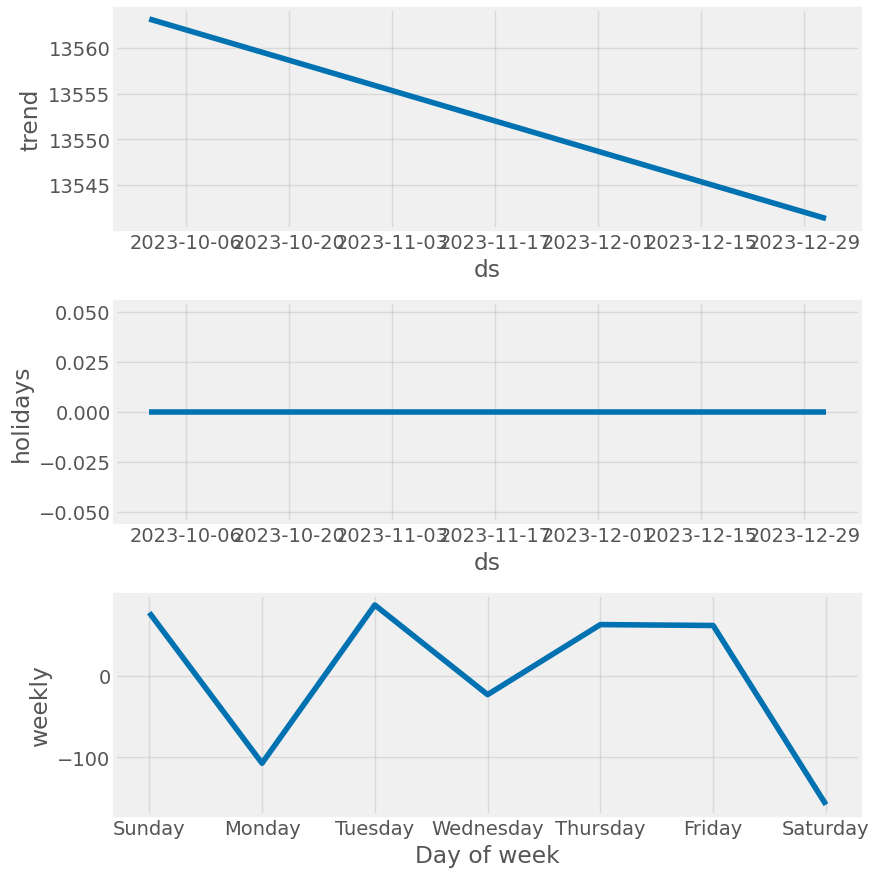

In [ ]:
fig = model_with_holidays.plot_components(
    test_fcst_with_hols)
plt.show()

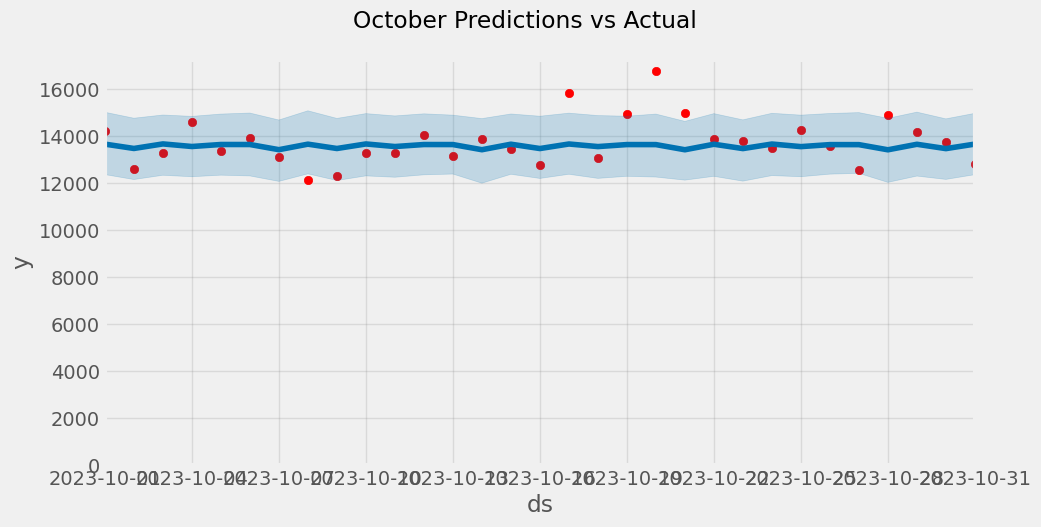

In [ ]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(test_df['ds'], test_df['y'], color='r')

fig = m.plot(test_fcst_with_hols, ax=ax)

# Convert the string dates to datetime objects
lower_bound = pd.to_datetime('2023-10-01')
upper_bound = pd.to_datetime('2023-10-31') # or any other appropriate upper bound for October

ax.set_xlim(lower_bound, upper_bound)
ax.set_ylim(0, daily_df['y'].max())
plot = plt.suptitle('October Predictions vs Actual')


In [ ]:
print(np.sqrt(mean_squared_error(y_true=test_df['y'],
                   y_pred=test_fcst_with_hols['yhat'])))

1028.0271721670545


In [ ]:
print(mean_absolute_error(y_true=test_df['y'],
                   y_pred=test_fcst_with_hols['yhat']))

801.414514676188


In [ ]:
print(mean_absolute_percentage_error(y_true=test_df['y'],
                   y_pred=test_fcst_with_hols['yhat']))

5.815581187454775


In [ ]:
future = m.make_future_dataframe(periods=365*24, freq='D', include_history=False)
forecast = model_with_holidays.predict(future)

In [ ]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2023-10-01,13640.459565
1,2023-10-02,13455.798477
2,2023-10-03,13649.326118
3,2023-10-04,13539.298290
4,2023-10-05,13624.831481


In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

best_rmse = float('inf')
best_params = {}

for params in ParameterGrid(param_grid):
    model = Prophet(**params, holidays=holiday_df)
    model.add_regressor('day_of_week')
    model.add_regressor('month')
    model.add_regressor('is_weekend')

    model.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])
    future = model.make_future_dataframe(periods=len(test_df), freq='D')
    future['day_of_week'] = future['ds'].dt.dayofweek
    future['month'] = future['ds'].dt.month
    future['is_weekend'] = future['day_of_week'].isin([5, 6]).astype(int)
    forecast = model.predict(future)
    forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]
    y_pred = forecast_test['yhat'].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppd3vl9kd/wdb5whoq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppd3vl9kd/_n04now9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53532', 'data', 'file=/tmp/tmppd3vl9kd/wdb5whoq.json', 'init=/tmp/tmppd3vl9kd/_n04now9.json', 'output', 'file=/tmp/tmppd3vl9kd/prophet_modelikht2u64/prophet_model-20250428154232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

In [ ]:
print(f"Best hyperparameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

Best hyperparameters: {'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_prior_scale': 0.01}
Best RMSE: 1018.5960243971924


In [ ]:
#Refit with best params
best_model = Prophet(**best_params, holidays = holiday_df)
best_model.add_regressor('day_of_week')
best_model.add_regressor('month')
best_model.add_regressor('is_weekend')

best_model.fit(train_df[['ds', 'y', 'day_of_week', 'month', 'is_weekend']])
future = best_model.make_future_dataframe(periods=len(test_df), freq='D')
future['day_of_week'] = future['ds'].dt.dayofweek
future['month'] = future['ds'].dt.month
future['is_weekend'] = future['day_of_week'].isin([5, 6]).astype(int)
forecast = best_model.predict(future)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppd3vl9kd/v5x65yxc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppd3vl9kd/9rsaz7o3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51611', 'data', 'file=/tmp/tmppd3vl9kd/v5x65yxc.json', 'init=/tmp/tmppd3vl9kd/9rsaz7o3.json', 'output', 'file=/tmp/tmppd3vl9kd/prophet_modellk41998x/prophet_model-20250428154251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:42:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


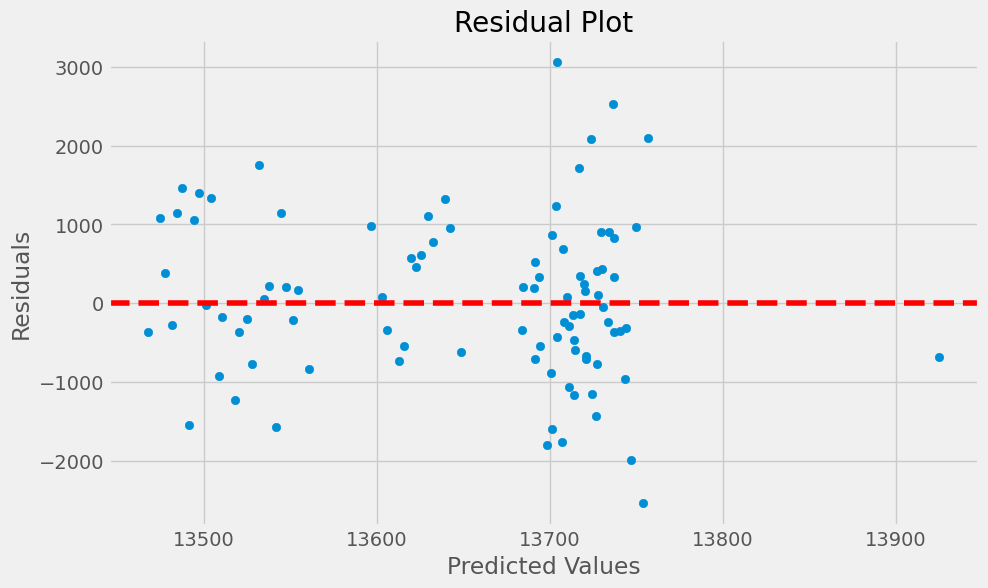

In [ ]:
#Residual Analysis
residuals = y_true - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# **LSTM Model**

**Create LSTM Sequence (Number of Days)**

In [ ]:
SEQ_LEN = 14  # past 14 days to predict next day

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Split before creating sequences
split_date = '2023-10-01'
train_data = daily_df[daily_df['ds'] < split_date]['y'].values
test_data = daily_df[daily_df['ds'] >= split_date]['y'].values

# Create sequences
X_train, y_train = create_sequences(train_data, SEQ_LEN)
X_test, y_test = create_sequences(test_data, SEQ_LEN)

# Reshape for LSTM: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((624, 14, 1), (624,), (79, 14, 1), (79,))

**Build LSTM Model**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(SEQ_LEN, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test).flatten()

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 219221232.0000 - val_loss: 141774752.0000
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 83337536.0000 - val_loss: 17265604.0000
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 24004980.0000 - val_loss: 56561964.0000
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 29959816.0000 - val_loss: 12527866.0000
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10882818.0000 - val_loss: 13004774.0000
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10998731.0000 - val_loss: 14862647.0000
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15000092.0000 - val_loss: 14282180.0000
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 11929692.0000 - val_loss: 14878018.0000
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13871631.0000 - val_loss: 21725366.0000
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16384944.0000 - val_loss: 18763886.0000
Epoch 1

**LSTM Model Evaluation**

LSTM RMSE: 1131.06
LSTM MAE: 895.54
LSTM MAPE: 6.52%


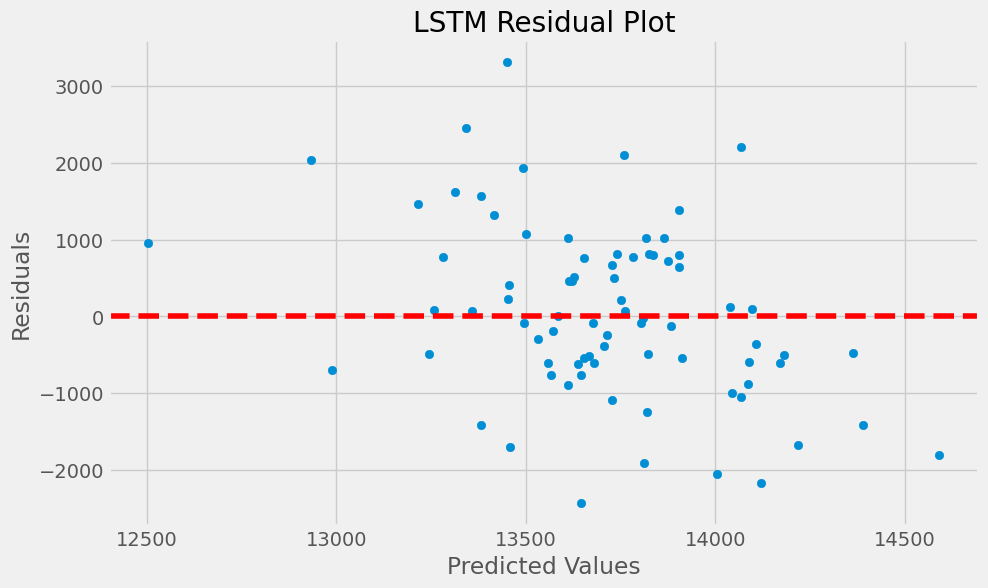

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"LSTM RMSE: {rmse:.2f}")
print(f"LSTM MAE: {mae:.2f}")
print(f"LSTM MAPE: {mape:.2f}%")

residuals = y_test - y_pred
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("LSTM Residual Plot")
plt.show()

**LSTM HyperTunning**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import numpy as np

param_grid = {
    'units': [32, 64, 128],
    'batch_size': [16, 32],
    'epochs': [30, 50],
    'learning_rate': [0.001, 0.0005],
    'dropout_rate': [0.0, 0.2],
    'num_layers': [1, 2]
}

best_rmse = float('inf')
best_params = None

import itertools

keys, values = zip(*param_grid.items())
for combo in itertools.product(*values):
    params = dict(zip(keys, combo))

    model = Sequential()
    for i in range(params['num_layers']):
        return_sequences = (i < params['num_layers'] - 1)
        model.add(LSTM(params['units'], activation='relu', return_sequences=return_sequences, input_shape=(X_train.shape[1], 1)))
        if params['dropout_rate'] > 0:
            model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

    y_pred = model.predict(X_test).flatten()

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        best_model = model

    print(f"Tested {params} --> RMSE: {rmse:.2f}")

print("\n")
print(f"Best hyperparameters: {best_params}")
print(f"Best LSTM RMSE: {best_rmse:.2f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Tested {'units': 32, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.001, 'dropout_rate': 0.0, 'num_layers': 1} --> RMSE: 1657.95


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
Tested {'units': 32, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.001, 'dropout_rate': 0.0, 'num_layers': 2} --> RMSE: 1146.48
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Tested {'units': 32, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'num_layers': 1} --> RMSE: 1693.30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
Tested {'units': 32, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.001, 'dropout_rate': 0.2, 'num_layers': 2} --> RMSE: 2242.65
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Tested {'units': 32, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.0005, 'dropout_rate': 0.0, 'num_layers': 1} --> RMSE: 6167.13
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
Tested {'units': 32, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.0005, 'dropout_rate': 0.0, 'num_layers': 2} --> RMSE: 3857.69
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Tested {'units': 32, 'batch_size': 16, 'epochs': 30, 'learning_rate': 0.0005, 'dropout_rate': 0.2, 'nu

**Predict Again with best LSTM Model**

In [ ]:
y_pred_best = best_model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae = mean_absolute_error(y_test, y_pred_best)
mape = np.mean(np.abs((y_test - y_pred_best) / y_test)) * 100

print(f"Best LSTM RMSE: {rmse:.2f}")
print(f"Best LSTM MAE: {mae:.2f}")
print(f"Best LSTM MAPE: {mape:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Best LSTM RMSE: 1090.06
Best LSTM MAE: 840.43
Best LSTM MAPE: 6.07%
